# Exploration of ESCO data set
Felix Zaussinger | 23.04.2021

## Core Analysis Goal(s)
1. Understand linkages between skills and occupations
2. Create adjacency matrix (occupational similiarity)

## Key Insight(s)
1. Co-occurence and cosine similiarity yield qualitatively similar results
2. Distance-based adjacency matrix can be efficiently calculated via the scipy squareform and pdist
functions
3. Co-occurence is probably biased and should be converted to "relatedness"

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

ESCO data set components

In [3]:
occ = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupations_en.csv"))
skill_groups = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skillGroups_en.csv"))
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))
occ_skills_mapping = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupationSkillRelations.csv"))


In [4]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA.csv"),
    index_col=0
)

df_metadata.greenness_vona_2018 = df_metadata.greenness_vona_2018.fillna(0)

# convert job zone to categorical var
df_metadata.job_zone = pd.Categorical(df_metadata.job_zone, ordered=True)

In [5]:
# dummy to exclude certain code sections
run = False

### Build occupation - skills matrix

In [6]:
if run:
    errors = 0
    skill_vectors = []

    for i in tqdm(range(len(occ))):
        occ_uri = occ.iloc[i, :][1]

        # lookup corresponding skills
        skill_list = occ_skills_mapping[occ_skills_mapping["occupationUri"] == occ_uri]

        # create vector
        skill_vector = [1 if skill in skill_list.skillUri.values else 0 for skill in skills.conceptUri.values]
        indices = [i for i, j in enumerate(skill_vector) if j == 1]

        # sanity check
        if len(skill_list.skillUri) != np.sum(skill_vector):
            errors += 1

        # append
        skill_vectors.append(skill_vector)

    # info
    print(errors)
    np.array(skill_vectors).shape

    # create df
    adj_matrix = pd.DataFrame(
        index=occ.conceptUri,
        columns=skills.conceptUri,
        data=np.array(skill_vectors)
    )

    # store
    adj_matrix.to_pickle(
        os.path.join(project_dir, "data", "processed", "adjacency_matrix.pkl")
    )

## Construct adjacency matrix based on different methods

In [7]:
adj_matrix = pd.read_pickle(
    os.path.join(project_dir, "data", "processed", "adjacency_matrix.pkl")
)

## Co-occurrence (unweighted)

In [8]:
if not os.path.exists(os.path.join(project_dir, "data", "processed", "occ_coo_sim.pkl")):
    cooccurence_matrix = np.matmul(adj_matrix.values, adj_matrix.values.transpose())

    # replace diagonal elements with 0
    np.fill_diagonal(a=cooccurence_matrix, val=0)

    df_sim_coo = pd.DataFrame(
        index=occ.conceptUri,
        columns=occ.conceptUri,
        data=cooccurence_matrix
    )

    df_sim_coo.to_pickle(
        os.path.join(project_dir, "data", "processed", "occ_coo_sim.pkl")
    )
else:
    df_sim_coo = pd.read_pickle(
        os.path.join(project_dir, "data", "processed", "occ_coo_sim.pkl")
    )

Normalisation of co-occurences to relatedness values

In [9]:

def compute_relatedness(mat, method="prob", fill_diag=True):
    """
    Copy of https://github.com/PABalland/EconGeo/blob/master/R/relatedness.r
    """
    Cij = mat
    Si = Cij.sum(axis=1)
    # Sj = Cij.sum(axis=1)
    Si = np.broadcast_to(Si, (len(Si), len(Si)))
    Sj = Si.transpose()
    T = Cij.flatten().sum()

    if method == "jaccard":
        relatedness = Cij / (Si + Sj - Cij)
    elif method == "cosine":
        relatedness = Cij / np.sqrt(Si * Sj)
    elif method == "association":
        relatedness = (Cij / T) / ((Si/T) * (Sj/T))
    elif method == "prob":
        relatedness = Cij / ( ( (Si/T) * (Sj/(T-Si)) + (Sj/T) * (Si/(T-Sj))) * (T/2) )
    else:
        raise IOError("Method name does not exist.")

    # replace diagonal elements with zeros
    if fill_diag:
        np.fill_diagonal(relatedness, 0)
    return relatedness

## Cosine similarity

In [10]:
if not os.path.exists(os.path.join(project_dir, "data", "processed", "occ_cos_sim.pkl")):
    dist_cos = squareform(pdist(adj_matrix.values, metric='cosine'))
    sim_cos = 1 - dist_cos

    df_sim_cos = pd.DataFrame(
        index=occ.conceptUri,
        columns=occ.conceptUri,
        data=sim_cos
    )

    df_sim_cos.to_pickle(
        os.path.join(project_dir, "data", "processed", "occ_cos_sim.pkl")
    )
else:
    df_sim_cos = pd.read_pickle(
    os.path.join(project_dir, "data", "processed", "occ_cos_sim.pkl")
)

### Visualise cosine-similiarity matrix

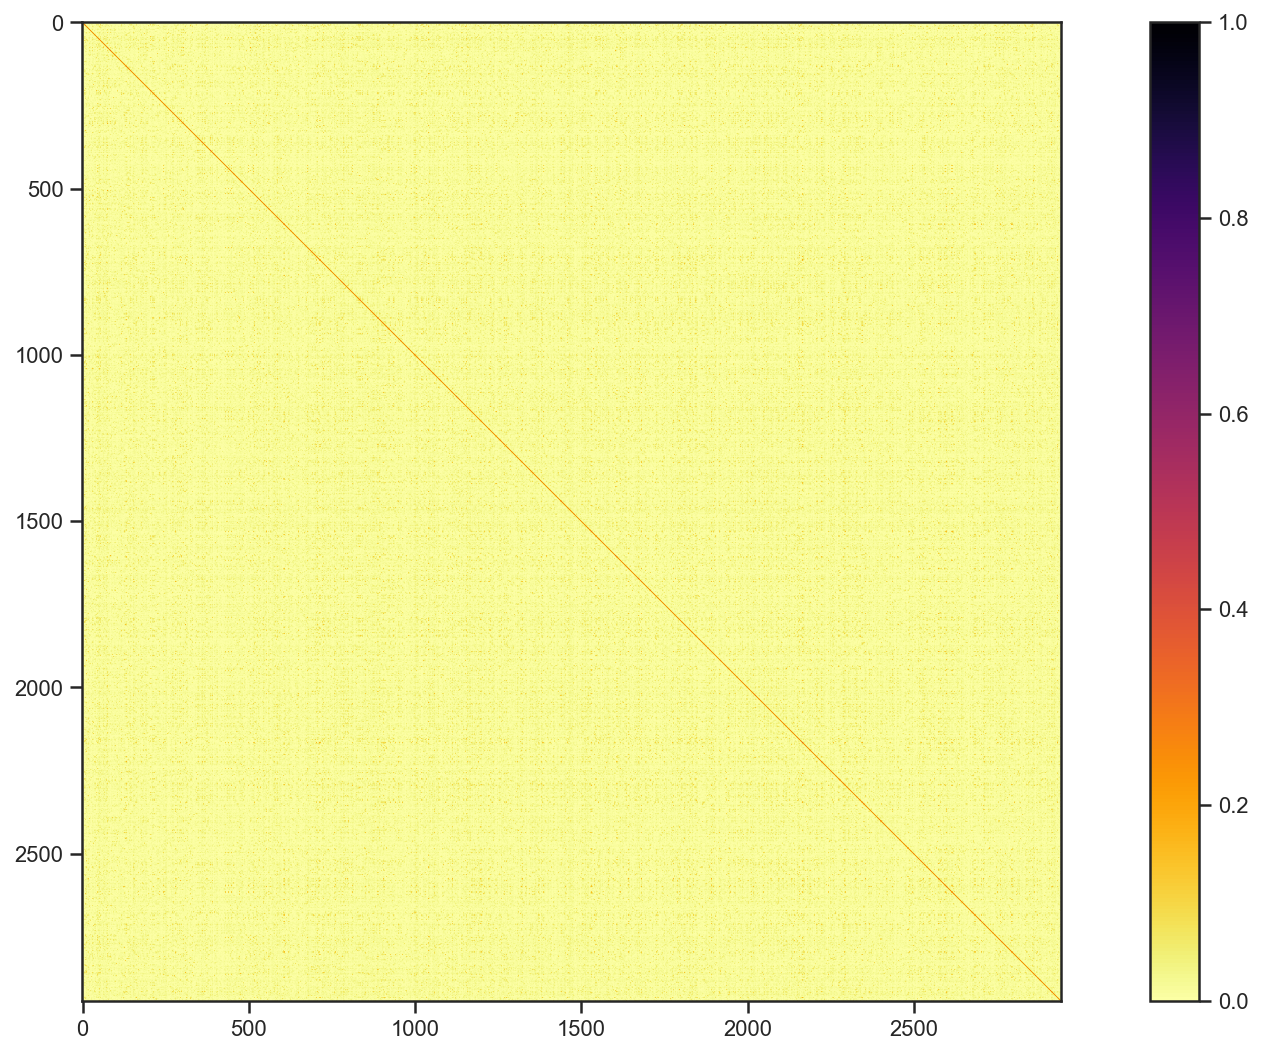

In [11]:
plt.imshow(df_sim_cos.values, cmap="inferno_r")
plt.colorbar()

(array([3.88942163e+01, 6.07431415e+00, 1.81792470e+00, 9.80675105e-01,
        5.57134281e-01, 3.38160244e-01, 2.25259157e-01, 1.73048759e-01,
        1.35950377e-01, 1.01035612e-01, 8.50801884e-02, 7.15972199e-02,
        6.85470883e-02, 4.48392465e-02, 4.17775613e-02, 3.63011885e-02,
        3.26733803e-02, 2.70468117e-02, 2.43895000e-02, 2.10389765e-02,
        2.47938735e-02, 2.24369535e-02, 1.86473960e-02, 1.59092096e-02,
        1.30785950e-02, 1.19925632e-02, 9.46234035e-03, 8.09902391e-03,
        6.14647749e-03, 5.97317455e-03, 5.45326574e-03, 5.09510634e-03,
        5.01423164e-03, 4.45966224e-03, 3.69712932e-03, 3.72023638e-03,
        4.17082401e-03, 4.40189459e-03, 5.97317455e-03, 5.29151634e-03,
        5.47637280e-03, 3.82421814e-03, 4.72539341e-03, 4.48276930e-03,
        5.27996281e-03, 4.78316105e-03, 4.51742989e-03, 9.10418094e-03,
        5.60346162e-03, 1.73765078e-02]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 

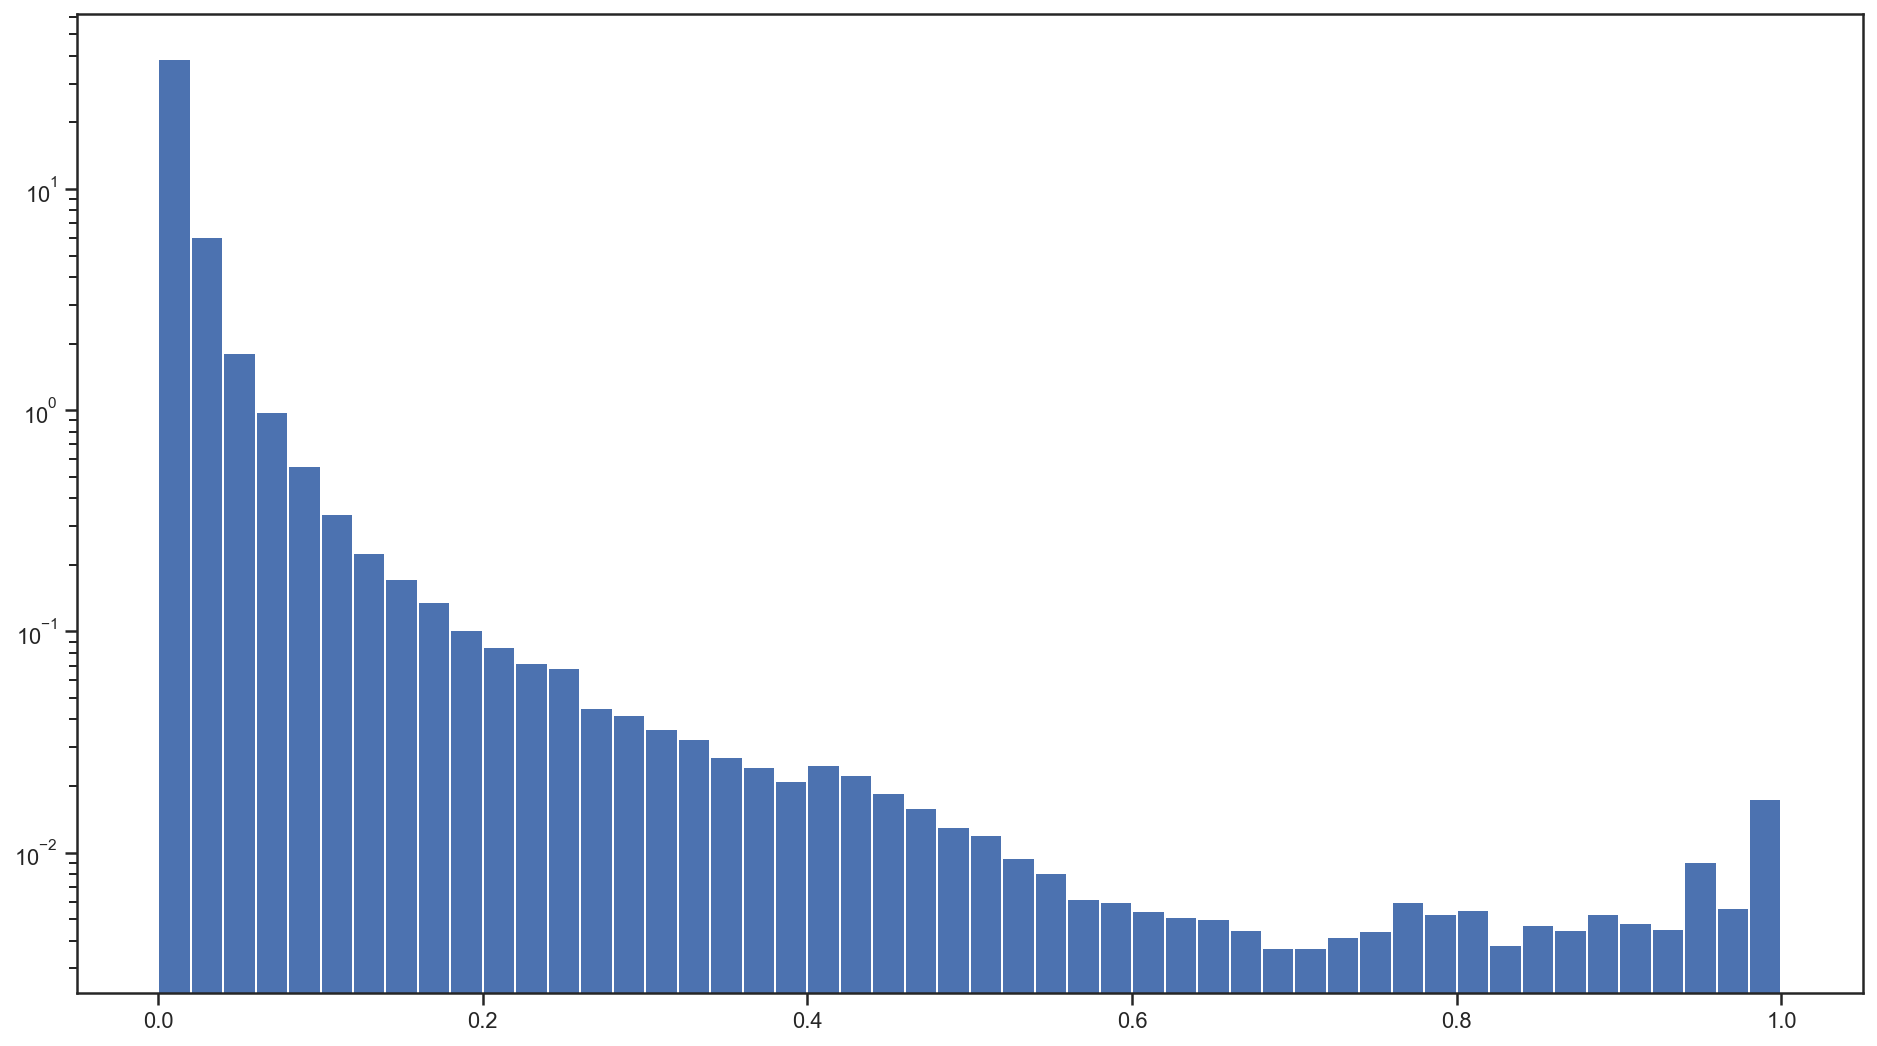

In [12]:
plt.hist(df_sim_cos.values.flatten(), density=True, bins=50, log=True)

In [13]:
# skilllab
df_sim_upeksha = pd.read_csv(
    os.path.join(data_processed, "occupation_adjacency_upeksha.csv"),
    index_col=0
)

sim_upeksha = df_sim_upeksha.values.flatten()

# nesta report
sim_kanders = np.load(
    os.path.join(data_raw, "mcc_data", "processed", "sim_matrices", "OccupationSimilarity_Combined.npy")
)

np.fill_diagonal(sim_kanders, 0)


(array([8.68876777e-01, 5.82752607e-01, 9.43736291e-01, 2.06094616e+00,
        3.35318473e+00, 4.61812493e+00, 5.67991136e+00, 6.26948567e+00,
        6.40650939e+00, 5.64854888e+00, 4.41387854e+00, 3.07777873e+00,
        1.99524970e+00, 1.28862538e+00, 8.22963251e-01, 5.02418388e-01,
        3.23400728e-01, 2.44026173e-01, 1.75283067e-01, 1.29161421e-01,
        9.40990266e-02, 7.18533392e-02, 5.89325722e-02, 5.64756031e-02,
        4.15256686e-02, 3.82709072e-02, 3.08826565e-02, 2.75585218e-02,
        2.35811224e-02, 1.92163890e-02, 1.74184658e-02, 1.52621140e-02,
        1.24235921e-02, 1.13425257e-02, 9.16883063e-03, 7.93167442e-03,
        7.60215150e-03, 5.53829744e-03, 5.05268472e-03, 5.72329277e-03,
        5.34752102e-03, 5.63657621e-03, 6.18578107e-03, 5.69438725e-03,
        6.70608041e-03, 7.40559397e-03, 7.44028060e-03, 6.24359211e-03,
        1.37532460e-02, 8.42306824e-03]),
 array([0.        , 0.01998499, 0.03996998, 0.05995496, 0.07993995,
        0.09992494, 0.1199

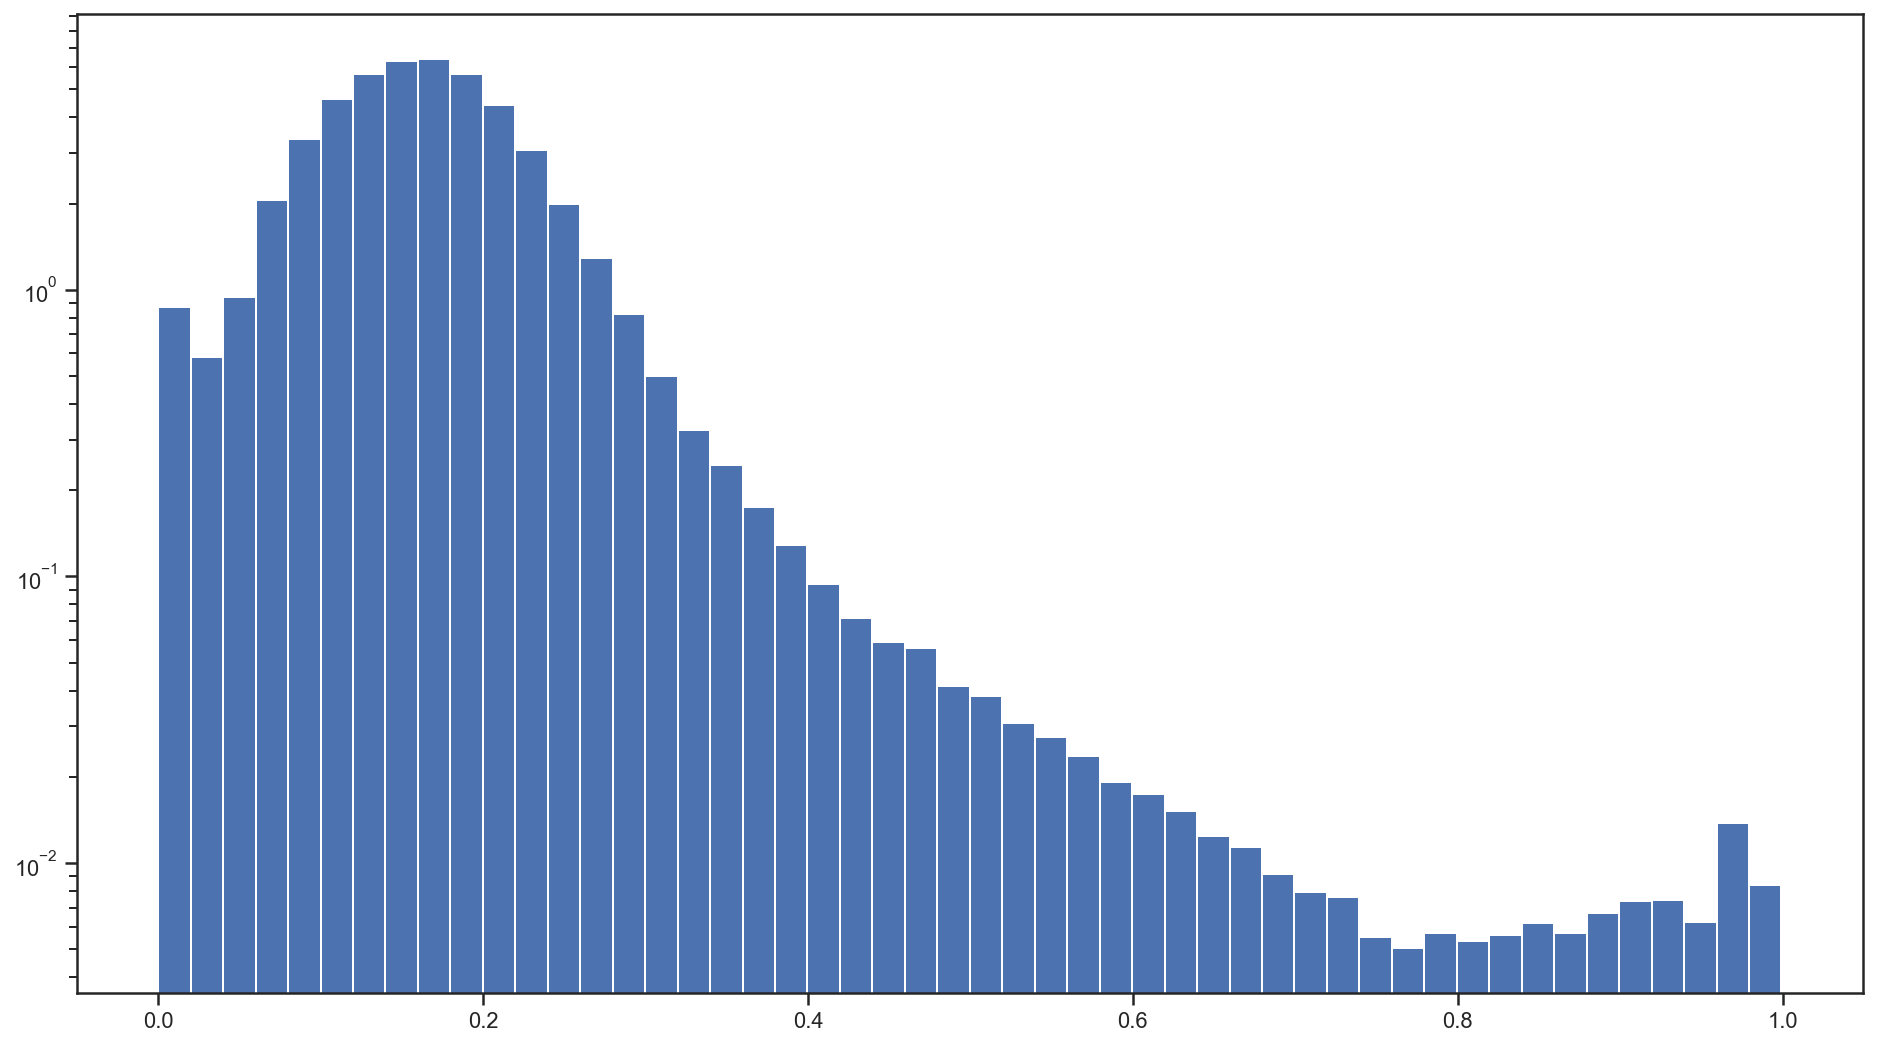

In [14]:
#plt.imshow(sim_kanders, cmap="Greens")
#plt.colorbar()

plt.hist(sim_kanders.flatten(), density=True, bins=50, log=True)


## Determine closest matches based on skill similiarity

In [15]:
# source: https://github.com/nestauk/mapping-career-causeways/blob/main/mapping_career_causeways/compare_nodes_utils.py
def find_closest(i, similarity_matrix, df):
    """
    Method for reporting the closest neighbours to a node i given a similarity matrix;
    useful during exploratory data analysis.
    Parameters
    ----------
    i (int OR None):
        Determines for which node where are assessing the closest neighbours;
        if i==None, a random node is chosen.
    similarity_matrix (numpy.ndarray):
        Similarity matrix determining the closeness between each pair of nodes.
    df (pandas.DataFrame):
        Dataframe to be used for reporting the closest neighbours; must have then
        same number of rows as the similarity matrix
    Returns
    -------
    df (pandas.DataFrame):
        The same input dataframe with an added column for similarity values
        between node i and the rest of the nodes, ordered in a descending order
        of similarity.
    """
    if type(i) == type(None):
        i = np.random.randint(similarity_matrix.shape[0])

    most_similar = np.flip(np.argsort(similarity_matrix[i,:]))
    similarity = np.flip(np.sort(similarity_matrix[i,:]))

    df = df.copy().loc[most_similar]
    df['similarity'] = similarity
    return df

In [16]:
uri_mining_assistant = "http://data.europa.eu/esco/occupation/efd5d3cb-3716-43b7-b21b-98e17f00e9eb"
df = pd.DataFrame(df_sim_cos.index.values, columns=["conceptUri"])
df[df.conceptUri == uri_mining_assistant]

,conceptUri
2764,http://data.europa.eu/esco/occupation/efd5d3cb...


In [17]:
# select source occupation
i=2763

# find closest occupations
sim_ranking = find_closest(
    i=i,
    similarity_matrix=sim_kanders,
    #similarity_matrix=df_sim_cos.values,
    df=df
)

# print source occupation
source_occ = df_metadata.loc[i, :]
print("Source occupation: {}".format(source_occ.preferred_label))

# merge metadata
result = pd.merge(
    sim_ranking,
    df_metadata[["concept_uri", "preferred_label", "greenness_vona_2018", "annual_earnings"]],
    left_on="conceptUri",
    right_on="concept_uri",
    how="left"
).drop(columns=["concept_uri"], axis=1)

# earnings ratio
result["earnings_ratio"] = result.annual_earnings / source_occ.annual_earnings

result.head(30)

#result.similarity.plot()

Source occupation: mining geotechnical engineer


,conceptUri,similarity,preferred_label,greenness_vona_2018,annual_earnings,earnings_ratio
0,http://data.europa.eu/esco/occupation/1790c821...,0.574149,mine geologist,0.937500,42983.000000,1.349807
1,http://data.europa.eu/esco/occupation/7b99007f...,0.561354,mine planning engineer,0.000000,36554.033333,1.147916
2,http://data.europa.eu/esco/occupation/e9665bdf...,0.484432,geotechnician,0.277778,27504.553459,0.863733
3,http://data.europa.eu/esco/occupation/b3855886...,0.481571,mine ventilation engineer,0.400000,34707.347469,1.089924
4,http://data.europa.eu/esco/occupation/a92a3e24...,0.465193,geophysicist,0.937500,42983.000000,1.349807
5,http://data.europa.eu/esco/occupation/62d3f108...,0.460423,mineral processing engineer,0.000000,36554.033333,1.147916
6,http://data.europa.eu/esco/occupation/5fd69ee2...,0.438189,mine development engineer,0.000000,36554.033333,1.147916
7,http://data.europa.eu/esco/occupation/d6d1af75...,0.433068,mine health and safety engineer,0.000000,36554.033333,1.147916
8,http://data.europa.eu/esco/occupation/c8e6cdcc...,0.418145,geochemist,0.937500,42983.000000,1.349807
9,http://data.europa.eu/esco/occupation/03b2f112...,0.416612,quarry engineer,0.000000,36554.033333,1.147916


### Compute correlation between adjacency matrices computed via different methods

In [18]:
from scipy.stats import kendalltau, pearsonr, spearmanr

ar_sim_cos = df_sim_cos.values
np.fill_diagonal(ar_sim_cos, 0)

sim_cos = ar_sim_cos.flatten()
sim_coo = df_sim_coo.values.flatten()
sim_prob = compute_relatedness(df_sim_coo.values, method="prob").flatten()
sim_jaccard = compute_relatedness(df_sim_coo.values, method="jaccard").flatten()
sim_cosine = compute_relatedness(df_sim_coo.values, method="cosine").flatten()
sim_association = compute_relatedness(df_sim_coo.values, method="association").flatten()

In [19]:
from src.visualization.visualize import correlation_matrix_plot

all_sim_matrices = pd.DataFrame.from_dict(
    data={
        "cosine": sim_cos,
        "coo": sim_coo,
        "coo_prob": sim_prob,
        "coo_jaccard": sim_jaccard,
        "coo_cosine": sim_cosine,
        "coo_association": sim_association,
        "upeksha": sim_upeksha,
        "nesta": sim_kanders.flatten()
    }
)

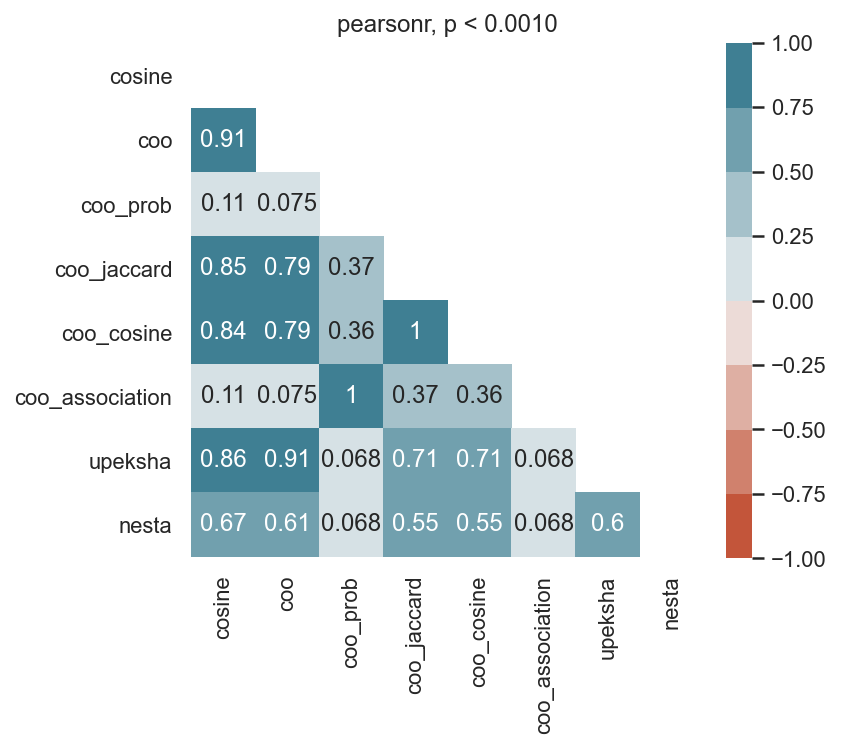

In [20]:
correlation_matrix_plot(
    df=all_sim_matrices,
    significance_level=0.001,
    figsize=(6, 6),
    function=pearsonr
)

plt.savefig(
    os.path.join(figure_dir, "corr_similarity_matrices.png"),
    dpi=150
)

## Visualize transition matrix

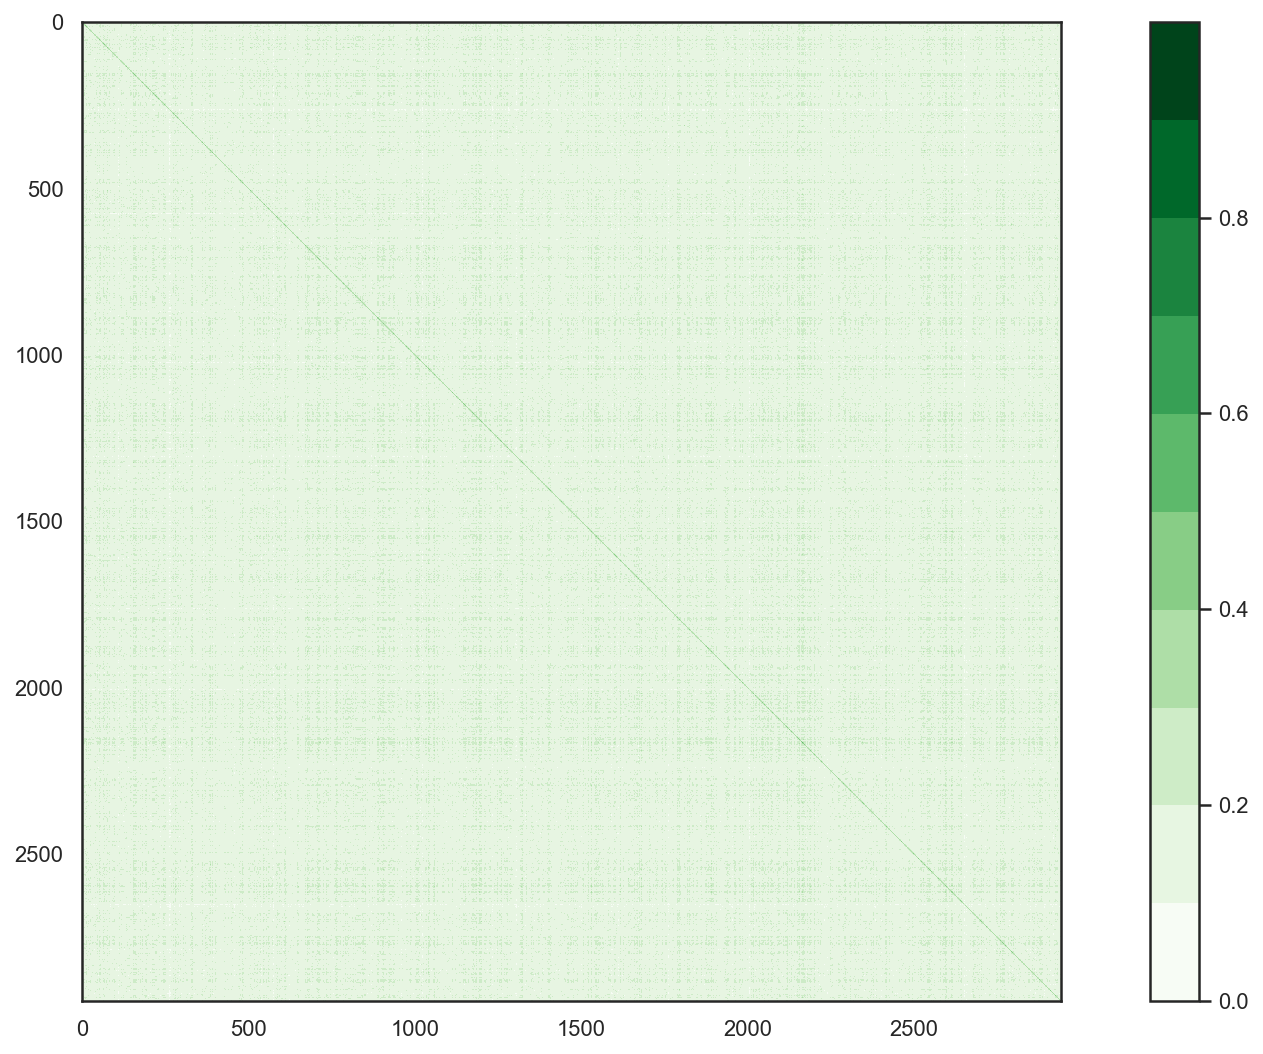

In [32]:
#np.fill_diagonal(sim_kanders, 0)

plt.imshow(sim_kanders, cmap=mpl.cm.get_cmap('Greens', 10))
plt.colorbar()